# ECSE 552 A1, Q2 



## dictionaries

In [ ]:
from sklearn.datasets import make_classification
import torch
import math 
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

## generating dataset

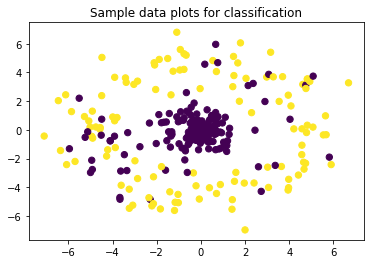

In [ ]:
DATA_SIZE = 900
data = []
label = [0, 1]
for i in range(DATA_SIZE):
  r = np.random.normal(0, 1)
  t = np.random.uniform(0, 2 * math.pi)
  if np.random.rand() > 0.5:
    x1 = r * math.cos(t)
    x2 = r * math.sin(t) 
    data += ([x1, x2, label[0]])
    
  else:
    x1 = (r + 5) * math.cos(t)
    x2 = (r + 5) * math.sin(t) 
    data += ([x1, x2, label[1]])


# convert pandas dataframe to pytorch tensor
targets_df = pd.DataFrame(data=data)
targets_df.columns = ['targets']
torch_tensor = torch.tensor(targets_df['targets'].values)
torch_tensor = np.reshape(torch_tensor, (DATA_SIZE, 3))
train, valid = random_split(torch_tensor,[600,300])
trainloader = DataLoader(train, batch_size=3)
validloader = DataLoader(valid, batch_size=3)
all_data_loader = DataLoader(torch_tensor, batch_size=3)


for i, batch in enumerate(validloader):
  X_valid = batch[:, :2]
  y_valid = batch[:, 2] 
  plt.scatter(X_valid[:,0],X_valid[:,1],s=40,c=y_valid)
  plt.title('Sample data plots for classification')


for i, batch in enumerate(trainloader):
  X_train = batch[:, :2]
  y_train = batch[:, 2]



## designing Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # network consists of 3 layers. 1 input(2 nodes), 1 hidden(4 nodes) and 1 output(2 nodes) layer
        # This applies Linear transformation to input data 
        self.fc1 = nn.Linear(2,5)
        # This applies linear transformation to produce output data
        self.fc2 = nn.Linear(5, 2)

   
    def forward(self,x):         
        #Activation function is Relu
        x = F.relu(self.fc1(x))
        #This produces output
        x = self.fc2(x)
        return x


## training model

In [ ]:
#Initialize the model        
model = Net()

if torch.cuda.is_available():
    model = model.cuda()

#Define loss criterion
criterion = nn.CrossEntropyLoss()

#Define the optimizer (try both)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

X_train = X_train.float()
y_train = y_train.type(torch.LongTensor)

X_valid = X_valid.float()
y_valid = y_valid.type(torch.LongTensor)

#Number of epochs
epochs = 1000

min_valid_loss = np.inf

# accuracy arrays for plot
train_acc = []
valid_acc = []

for e in range(epochs):
  train_loss = 0.0
  if torch.cuda.is_available():
 
    X_train, y_train = X_train.cuda(), y_train.cuda()

  # Clear the gradients
  optimizer.zero_grad()
  # Forward Pass                               
  target = model.forward(X_train)
  
  # Find the Loss
  loss = criterion(target, y_train)
  # Calculate gradients
  loss.backward()
  # Update Weights
  optimizer.step()
  # Calculate Loss
  train_loss += loss.item()
  train_acc.append(1 - (train_loss / len(trainloader)))

  valid_loss = 0.0
  model.eval()     # Optional when not using Model Specific layer
 
  if torch.cuda.is_available():
    X_valid, y_valid = X_valid.cuda(), y_valid.cuda()
        
  # Forward Pass
  target = model.forward(X_valid)
  # Find the Loss
  loss = criterion(target, y_valid)
  # Calculate Loss
  valid_loss += loss.item()
  valid_acc.append(1 - (valid_loss / len(validloader)))
  print(f'Epoch {e+1} \t\t Training Accuracy: {1 - (train_loss / len(trainloader))} \t\t Validation Accuracy: {1 - (valid_loss / len(validloader))}')
    
  if min_valid_loss > valid_loss:
      print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
      min_valid_loss = valid_loss
        
      # Saving State Dict
      torch.save(model.state_dict(), 'saved_model.pth')


Epoch 1 		 Training Accuracy: 0.997065604031086 		 Validation Accuracy: 0.9929064387083053
Validation Loss Decreased(inf--->0.709356) 	 Saving The Model
Epoch 2 		 Training Accuracy: 0.9970810532569885 		 Validation Accuracy: 0.9929294174909592
Validation Loss Decreased(0.709356--->0.707058) 	 Saving The Model
Epoch 3 		 Training Accuracy: 0.9970965161919594 		 Validation Accuracy: 0.9929524493217469
Validation Loss Decreased(0.707058--->0.704755) 	 Saving The Model
Epoch 4 		 Training Accuracy: 0.9971119904518128 		 Validation Accuracy: 0.9929755336046219
Validation Loss Decreased(0.704755--->0.702447) 	 Saving The Model
Epoch 5 		 Training Accuracy: 0.9971274730563163 		 Validation Accuracy: 0.992998668551445
Validation Loss Decreased(0.702447--->0.700133) 	 Saving The Model
Epoch 6 		 Training Accuracy: 0.9971429598331452 		 Validation Accuracy: 0.9930218535661698
Validation Loss Decreased(0.700133--->0.697815) 	 Saving The Model
Epoch 7 		 Training Accuracy: 0.9971584495902062 		 V

## plotting accuracy

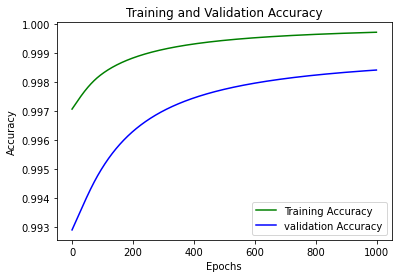

In [ ]:
epochs = np.array([i for i in range(1000)])
plt.plot(epochs, np.reshape(train_acc, 1000), 'g', label='Training Accuracy')
plt.plot(epochs, np.reshape(valid_acc, 1000), 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## plotting decision boundary

In [ ]:
# coordinates for the first input pairs
x1_1, x2_1 = X_train[0]

# coordinates for the second input pairs
x1_2, x2_2 = X_train[1]

nodes = 5
x_coord = []
y_coord = []

for i in range(nodes):
    w1, w2 = model.fc1.weight[i]
    b = model.fc1.bias[i]
    new_x1_1 = (-x2_1 * w2 - b) / w1
    new_x1_2 = (-x2_2 * w2 - b) / w1
    x_coord.append([new_x1_1, new_x1_2])
    y_coord.append([x2_1, x2_2])


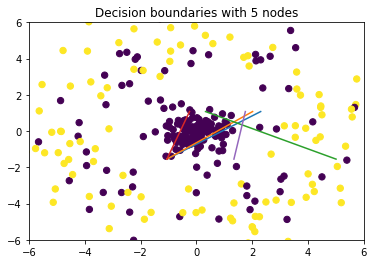

In [ ]:
for i, batch in enumerate(validloader):
    X_valid = batch[:, :2]
    y_valid = batch[:, 2] 
    plt.scatter(X_valid[:,0],X_valid[:,1],s=40,c=y_valid)
    plt.title('Decision boundaries with 5 nodes')

for i in range(nodes):  
    plt.plot(x_coord[i], y_coord[i])


plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.show()